<div align="center">
<font color="blue"><h1>UAVSAR Radar Path Length Atmospheric Correction</h1>
<h3>Jack Tarricone, September 2021</h3></font></div>

#In this tutorial, we will walk through examples of reprojecting raster datasets and working with coordinate #transformations with GDAL. We will focus on these common operations 

1. Converting coordinates from one projection system to another
2. Reprojecting geocoded rasters 
3. Reprojecting swath data
   - Using GCPs
   - Using geolocation arrays

We assume that you have already completed the tutorial on raster data manipulation and are familiar with raster data representation in GDAL.

In [8]:
###The usual python imports for the notebook
%matplotlib notebook
from osgeo import gdal, ogr, osr
import matplotlib.pyplot as plt
from spectral import * # for reading raw envi data
import os
import glob
import re
import codecs
from matplotlib import pyplot as plt
import subprocess

gdal.UseExceptions()

#Utility function to load data

def loadData(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    #Data array
    data = ds.GetRasterBand(band).ReadAsArray()
    #Map extent
    trans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    extent = [trans[0], trans[0] + xsize * trans[1],
            trans[3] + ysize*trans[5], trans[3]]
    
    ds = None
    return data, extent


## Make SLC header

As with all UAVSAR the SLC (Single Look Complex) data types comes in a flat binary format with annotation file containing the information needed to properly display and geocode it. Below is a function that searches through the annotation file, pulls out the information needed, and creates a properlly formated ENVI header. The header alsos the data to be read in, visualized, and manipulated in python. 

For the SLC data specifically we know that data type, byte, order, header offset are constant. We just need the number of lines and samples (columns and rows).

In [21]:
def make_slc_header(folder):
    """
    Builds a header file for the input UAVSAR .grd file,
    allowing the data to be read as a raster dataset.
    :param folder:   the folder containing the UAVSAR .grd and .ann files
    """


    os.chdir(folder)

    # Empty lists to put information that will be recalled later.
    Lines_list = []
    Samples_list = []
    Files_list = []

    # Step 1: Look through folder and determine how many different flights there are
    # by looking at the HDR files.
    for files in os.listdir(folder):
        if files [-4:] == ".lkv" or files [-4:] == ".llh":
            newfile = open(files + ".hdr", 'w')
            newfile.write("""ENVI
description = UAVSAR SLC Header
samples = NSAMP
lines = NLINE
bands = 3
header offset = 0
data type = 4
interleave = bip
sensor type = UAVSAR L-Band
byte order = 0
                """)
            newfile.close()
            if files[0:9] not in Files_list:
                Files_list.append(files[0:9])

    #Variables used to recall indexed values.
    var1 = 0
    
    #Step 2: Look through the folder and locate the annotation file(s).
    # These can be in either .txt or .ann file types. 
    for files in os.listdir(folder):
        if Files_list[var1] and files[-4:] == ".txt" or files[-4:] == ".ann":
            #Step 3: Once located, find the info we are interested in and append it to
            # the appropriate list. We limit the variables to <=1 so that they only
            # return two values (one for each polarization of
            searchfile = codecs.open(files, encoding = 'windows-1252', errors='ignore')
            for line in searchfile:
                if "llh_1_2x8.set_rows" in line:
                    Lines = line[75:81]
                    print(Lines)
                    if Lines not in Lines_list:
                        Lines_list.append(Lines)

                elif "llh_1_2x8.set_cols" in line:
                    Samples = line[75:81]
                    print(Samples)
                    if Samples not in Samples_list:
                        Samples_list.append(Samples)
                 
            #Reset the variables to zero for each different flight date.
            var1 = 0
            searchfile.close()


    # Step 3: Open .hdr file and replace data for all type 4 (real numbers) data
    # this all the .grd files expect for .int
    for files in os.listdir(folder):
        if files[-4:] == ".hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    else:
                        sources.write(re.sub(line, line, line))
    
    
     #Step 4: Now we have an .hdr file, the data is geocoded and can be loaded into python with rasterio
     #once loaded in we use gdal.Translate to convert and save as a .tiff
    
    # Dan, if you wanted to convert to UTM, it would probably be best in this step
    # but also possibly when making the header, where lat/lon is specified 

    print(".hdr has been created")
    return


In [22]:
folder = ("/Volumes/JT/projects/uavsar/jemez/look_vector/BU/hdr_test")
make_slc_header(folder)

8636  
4895  
.hdr has been created


In [23]:
print(glob.glob("/Volumes/JT/projects/uavsar/jemez/look_vector/BU/hdr_test/*"))

['/Volumes/JT/projects/uavsar/jemez/look_vector/BU/hdr_test/alamos_35915_03_BU_s1_2x8.lkv', '/Volumes/JT/projects/uavsar/jemez/look_vector/BU/hdr_test/alamos_35915_20005_003_200212_L090HH_03_BU.ann', '/Volumes/JT/projects/uavsar/jemez/look_vector/BU/hdr_test/alamos_35915_03_BU_s1_2x8.lkv.hdr']


## Load raw binary SLC data

In [24]:
img = envi.open("/Volumes/JT/projects/uavsar/jemez/look_vector/BU/hdr_test/alamos_35915_03_BU_s1_2x8.lkv.hdr")

In [30]:
img_open = img.open_memmap(writeable = True) 
img_band = img_open[:,:,2] 
#envi.save_image('new_image.bsq', ext='bsq', interleave = 'BSQ')

<IPython.core.display.Javascript object>


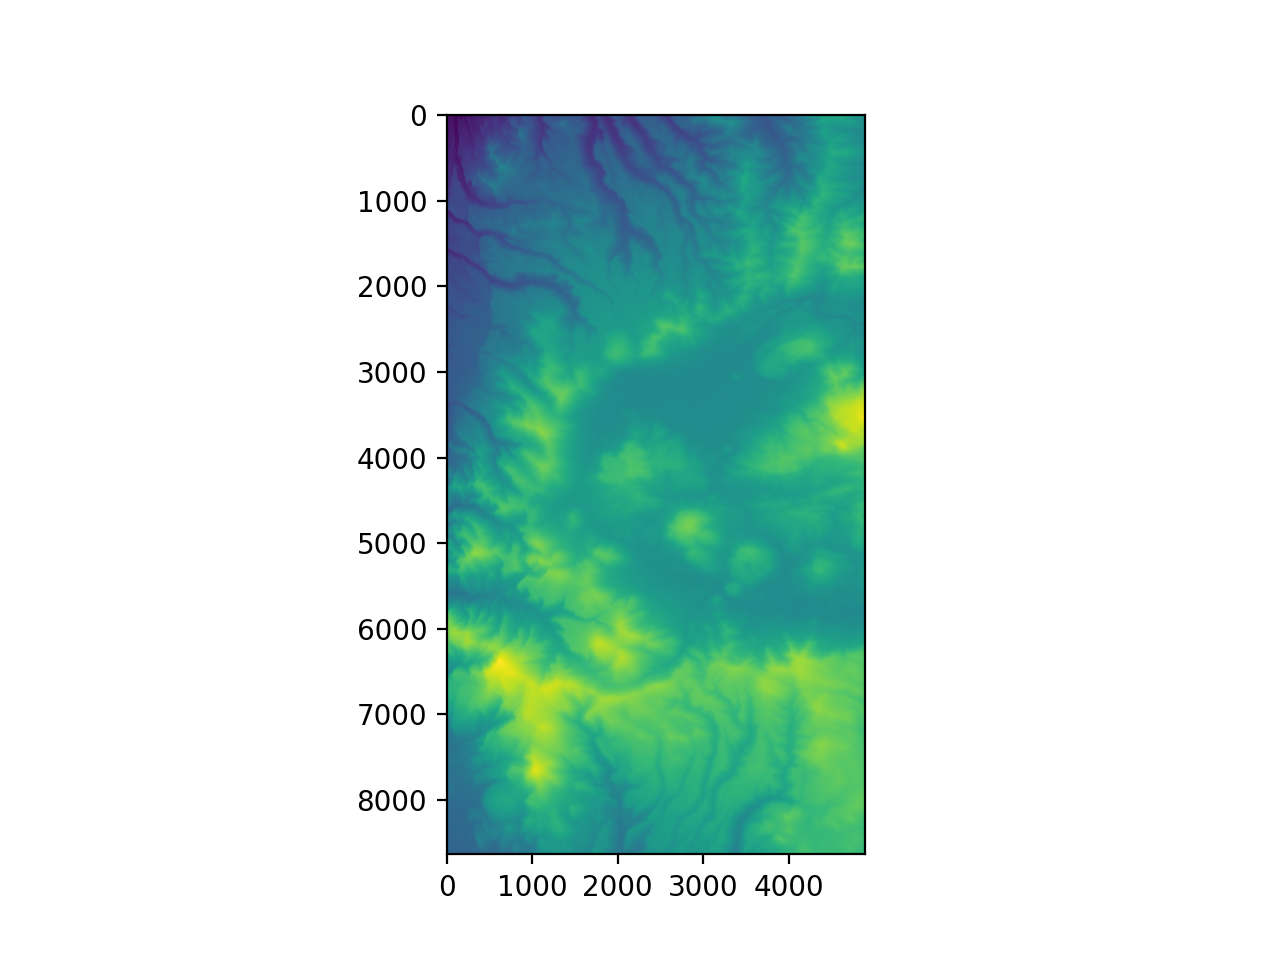

In [31]:
plt.imshow(img_band)

### b. Geocoding using geolocation arrays

*Note that this section requires you to have processed an interferogram!*

In this section we will provide programmatic examples of how pixel-by-pixel lon/lat or x/y arrays for swath imagery can be used for directly geocoding the data without any specialized radar processing tools. Note that ISCE already generates these files as part of the "topo" processing step in stripmapApp.py or topsApp.py. The main requirement is that these lon/lat or x/y arrays have the same dimensions as the raster image that you are trying to geocode. 

#### Locating a pixel with known location in a SAR/InSAR image

Before moving to geocoding entire images, we often encounter the use case where people want to quickly identify a known feature (say a GPS station or a building) in a radar image. This is often challenging without tools specialized for radar processing. However, if geolocation arrays are available with the radar image- this can be easily accomplished using GDAL's coordinate transformation features. We will demonstrate this with an example.

We have included the outputs from a stripmapApp.py processing run in the subfolder named **stripmap**. This is a pair processed over Hawaii. Location 119.7429N, -155.0750E represents the tip of an ocean wall near the Hilo airport (using Google Earth). We will try to locate this pixel in the full resolution correlation image in radar coordinates (topophase.cor.full). We will use the full resolution lat (lat.rdr.full) and lon (lon.rdr.full) files for this. 

In [ ]:
def radarGeometryTransformer(infile, latfile, lonfile, epsg=4326):
    '''
    Create a coordinate transformer to convert map coordinates to radar image line/pixels.
    '''
    
    driver = gdal.GetDriverByName('VRT')
    inds = gdal.OpenShared(infile, gdal.GA_ReadOnly)
    tempds = driver.Create('', inds.RasterXSize, inds.RasterYSize, 0)
    inds = None
    
    tempds.SetMetadata({'SRS' : 'EPSG:{0}'.format(epsg),
                        'X_DATASET': lonfile,
                        'X_BAND' : '1',
                        'Y_DATASET': latfile,
                        'Y_BAND' : '1',
                        'PIXEL_OFFSET' : '0',
                        'LINE_OFFSET' : '0',
                        'PIXEL_STEP' : '1',
                        'LINE_STEP' : '1'}, 'GEOLOCATION')
    
    trans = gdal.Transformer( tempds, None, ['METHOD=GEOLOC_ARRAY'])
    
    return trans    

In [ ]:
###Lets create a transformer for our dataset and test
#trans = radarGeometryTransformer('stripmap/geometry/z.rdr.full.vrt', 
                                 #'stripmap/geometry/lat.rdr.full.vrt',
 #                                'stripmap/geometry/lon.rdr.full.vrt')
#
###Checkour our location of interest
#success, location = trans.TransformPoint(1, -155.0750, 19.7429, 0.)
#if not success:
#    print('Location outside the geolocation array range')

In [ ]:
###Lets plot this on a raster to confirm the peak location
data, ext = loadData('/Users/jacktarricone/warp_test/good_llh_vrt/up.vrt')
plt.imshow(data)
data = None

#### Geocoding a full image

We can use the geolocation arrays mechanism to geocode the entire image using the standard **gdalwarp** interface. We will achieve this by creating a VRT file with the same information as the python function shown above.

In [ ]:
def geocodeUsingGdalWarp(infile, latfile, lonfile, outfile,
                         insrs=4326, outsrs=None,
                         spacing=None, fmt='GTiff', bounds=None,
                         method='near'):
    '''
    Geocode a swath file using corresponding lat, lon files
    '''
    sourcexmltmpl = '''    <SimpleSource>
      <SourceFilename>{0}</SourceFilename>
      <SourceBand>{1}</SourceBand>
    </SimpleSource>'''
    
    driver = gdal.GetDriverByName('VRT')
    tempvrtname = '/Users/jacktarricone/warp_test/good_llh_vrt/temp_ele.vrt'
    inds = gdal.OpenShared(infile, gdal.GA_ReadOnly)
    
    tempds = driver.Create(tempvrtname, inds.RasterXSize, inds.RasterYSize, 0)
    
    for ii in range(inds.RasterCount):
        band = inds.GetRasterBand(1)
        tempds.AddBand(band.DataType)
        tempds.GetRasterBand(ii+1).SetMetadata({'source_0': sourcexmltmpl.format(infile, ii+1)}, 'vrt_sources')
  
    sref = osr.SpatialReference()
    sref.ImportFromEPSG(insrs)
    srswkt = sref.ExportToWkt()

    tempds.SetMetadata({'SRS' : srswkt,
                        'X_DATASET': lonfile,
                        'X_BAND' : '1',
                        'Y_DATASET': latfile,
                        'Y_BAND' : '1',
                        'PIXEL_OFFSET' : '0',
                        'LINE_OFFSET' : '0',
                        'PIXEL_STEP' : '1',
                        'LINE_STEP' : '1'}, 'GEOLOCATION')
    
    band = None
    tempds = None 
    inds = None
    
    if spacing is None:
        spacing = [None, None]
    
    warpOptions = gdal.WarpOptions(format=fmt,
                                   xRes=spacing[0], yRes=spacing[0],
                                   dstSRS=outsrs, outputBounds = bounds, 
                                   resampleAlg=method, geoloc=True)
    gdal.Warp(outfile, tempvrtname, options=warpOptions)



In [ ]:
### Create and visualize geocoded output for elevation
# use proper pixel size!
geocodeUsingGdalWarp('/Users/jacktarricone/warp_test/good_llh_vrt/.vrt',
                     '/Users/jacktarricone/warp_test/good_llh_vrt/lat.vrt',
                     '/Users/jacktarricone/warp_test/good_llh_vrt/lon.vrt',
                     '/Volumes/JT/projects/uavsar/jemez/look_vector/geocoded_up_raw.tif',
                     spacing=[.00005556,.00005556])

geodata, geoext = loadData('/Volumes/JT/projects/uavsar/jemez/look_vector/geocoded_up_raw_TESTING.tif', band=1)

plt.figure()
plt.imshow(geodata, extent=geoext, cmap='gray')
plt.show()

In [ ]:
# north

geocodeUsingGdalWarp('/Users/jacktarricone/warp_test/good_llh_vrt/north.vrt',
                     '/Users/jacktarricone/warp_test/good_llh_vrt/lat.vrt',
                     '/Users/jacktarricone/warp_test/good_llh_vrt/lon.vrt',
                     '/Volumes/JT/projects/uavsar/jemez/look_vector/geocoded_north_raw.tif',
                     spacing=[.00005556,.00005556])

geodata, geoext = loadData('/Volumes/JT/projects/uavsar/jemez/look_vector/geocoded_north_raw.tif', band=1)

plt.figure()
plt.imshow(geodata, extent=geoext, cmap='gray')
plt.show()

## Other features to keep an eye on

1. **gdaldem** is an utility that allows one to apply color palettes to raster images. Very fast and can use custom color palettes. Compatible with GMT's cpt files. (http://www.gdal.org/gdaldem.html)

2. **gdal_rasterize** allows users to rasterize shapefiles / vector formats. (http://www.gdal.org/gdal_rasterize.html)

3. **gdal_edit.py** allows users to edit raster metadata on the command line. (http://www.gdal.org/gdal_edit.html)